In [14]:
import os
import psycopg2 as psycopg
import pandas as pd
import numpy as np
import psycopg
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from autofeat import AutoFeatRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import time

#### Этап 2: Исследовательский Анализ Данных (EDA)

In [2]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] =  os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [ ]:
EXPERIMENT_NAME = "EDA and plots"
RUN_NAME = "Nick_projecr _eda"

ASSETS_DIR = "assets"

os.mkdir(ASSETS_DIR)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

In [3]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

TABLE_NAME = "flat_cleaned_churn"

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]
    
df = pd.DataFrame(data, columns=columns)

In [4]:
def df_info(df):
    display(df.sample(10))
    display(df.isna().sum())
    display(df.info())
    display(df.shape)
    display(df.describe())
df_info(df)

,id,build_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,target
5892,5893,1117,1950-01-01,1,55.799355,37.516747,3.00,55,6,true,3,8.00,29.000000,2,false,false,46.000000,16200000.0
7774,7775,12453,1978-01-01,4,55.871010,37.562881,2.50,191,12,true,5,7.00,45.500000,3,false,false,65.000000,13999999.0
15273,15274,3361,1960-01-01,1,55.831020,37.659424,2.70,152,8,true,2,7.00,30.000000,2,false,false,47.099998,10000000.0
4116,4117,8620,1969-01-01,6,55.792221,37.613628,2.64,104,14,true,11,9.51,19.440001,1,false,false,34.770000,14900000.0
6651,6652,13272,1981-01-01,4,55.646015,37.712696,2.70,190,12,true,12,8.60,20.799999,1,false,false,39.000000,7600000.0
7689,7690,9524,1971-01-01,4,55.781822,37.640533,2.64,143,9,true,1,6.70,18.799999,1,false,false,32.799999,10300000.0
2209,2210,24430,2019-01-01,2,55.718822,37.426193,2.85,309,23,true,12,11.00,35.000000,2,false,false,64.690002,13900000.0
2785,2786,2580,1959-01-01,1,55.674850,37.596310,2.70,70,5,false,4,9.00,52.000000,3,false,false,74.000000,18000000.0
14816,14817,4005,1961-01-01,4,55.822689,37.600533,2.64,80,5,false,5,6.00,27.000000,2,false,false,46.000000,12500000.0
15084,15085,358,1917-01-01,1,55.774269,37.680416,3.00,14,4,false,2,9.00,45.000000,3,false,false,62.700001,12800000.0


id                   0
build_id             0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
target               0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 17521 non-null  int64         
 1   build_id           17521 non-null  int64         
 2   build_year         17521 non-null  datetime64[ns]
 3   building_type_int  17521 non-null  object        
 4   latitude           17521 non-null  float64       
 5   longitude          17521 non-null  float64       
 6   ceiling_height     17521 non-null  float64       
 7   flats_count        17521 non-null  int64         
 8   floors_total       17521 non-null  int64         
 9   has_elevator       17521 non-null  object        
 10  floor              17521 non-null  int64         
 11  kitchen_area       17521 non-null  float64       
 12  living_area        17521 non-null  float64       
 13  rooms              17521 non-null  int64         
 14  is_apa

None

(17521, 18)

,id,build_id,build_year,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,target
count,17521.000000,17521.000000,17521,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,1.752100e+04
mean,8761.000000,11347.842418,1978-11-29 00:30:44.278294656,55.738301,37.611767,2.685381,161.009703,11.550254,5.898065,8.257431,28.468097,1.888933,49.360562,1.122007e+07
min,1.000000,5.000000,1902-01-01 00:00:00,55.466152,37.200352,2.300000,1.000000,1.000000,1.000000,1.800000,0.000000,1.000000,12.650000,6.000000e+05
25%,4381.000000,5984.000000,1965-01-01 00:00:00,55.661861,37.511875,2.640000,80.000000,8.000000,3.000000,6.000000,19.799999,1.000000,38.000000,8.400000e+06
50%,8761.000000,10811.000000,1974-01-01 00:00:00,55.739178,37.599266,2.640000,128.000000,12.000000,5.000000,8.200000,28.799999,2.000000,45.099998,1.050000e+07
75%,13141.000000,16272.000000,1995-01-01 00:00:00,55.817577,37.727669,2.700000,215.000000,16.000000,8.000000,10.000000,35.000000,2.000000,58.099998,1.350000e+07
max,17521.000000,24620.000000,2023-01-01 00:00:00,56.009346,37.946411,3.250000,482.000000,27.000000,17.000000,15.900000,68.199997,5.000000,95.000000,2.224400e+07
std,5058.021369,6412.660787,NaN,0.100712,0.141077,0.152389,101.127958,5.002248,4.056324,2.138494,11.792972,0.769268,14.358618,3.724475e+06


In [5]:
df['build_year'] = pd.to_datetime(df['build_year']).dt.year

In [51]:
#df.sample(3)

In [42]:
#len(df[df.duplicated() == True])

0

In [6]:
count_zero_living_area = df.query('living_area == 0').shape[0]
print('Количество строк, где значение столбца living_area равно 0:', count_zero_living_area)

Количество строк, где значение столбца living_area равно 0: 732


In [78]:
#df.query('living_area == 0 & kitchen_area == 0 & total_area == 0')

,id,build_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,target


In [36]:
#zero_living_area_rows = df.query('living_area == 0')

#difference = zero_living_area_rows['total_area'] - zero_living_area_rows['kitchen_area']

# Заменяю нулевые значения в living_area рассчитанными значениями, не допуская отрицательных значений
#filled_values = difference.apply(lambda x: max(x, 0))
#df.loc[zero_living_area_rows.index, 'living_area'] = filled_values

# Проверка наличия отрицательных значений после заполнения
#if (df['living_area'] < 0).any():
    #print('Обнаружены отрицательные значения после заполнения')
#else:
    #print('Значения успешно заполнены')

In [79]:
df.studio.value_counts()

studio
false    17521
Name: count, dtype: int64

In [7]:
unique_counts = df.nunique()
columns_to_drop = unique_counts[unique_counts < 2].index
df = df.drop(columns=columns_to_drop)

2024-05-15 08:10:45,935 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-15 08:10:45,948 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


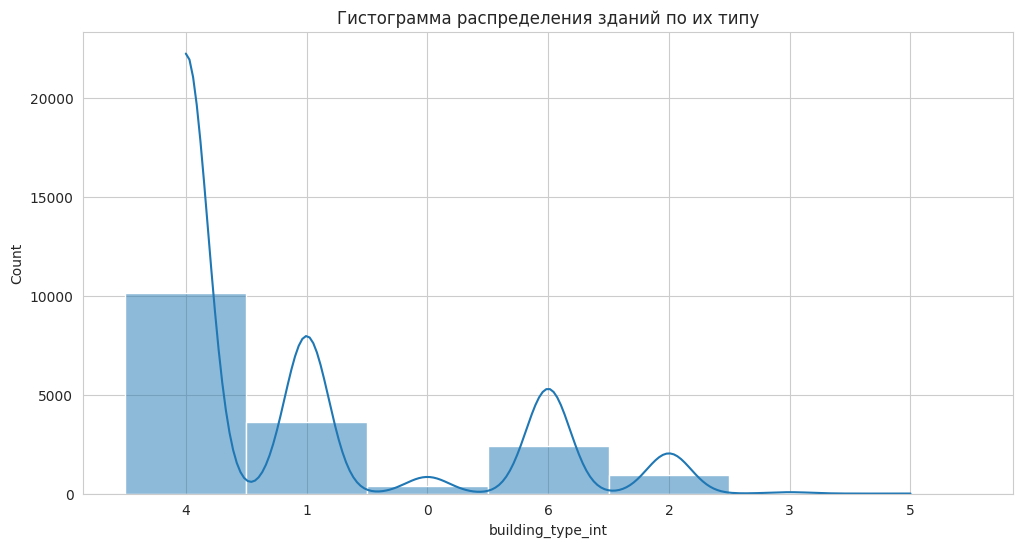

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x="building_type_int", kde=True, ax=ax)
plt.title('Гистограмма распределения зданий по их типу')
plt.show()

# Сохранение картинки в директорию
fig.savefig(os.path.join(ASSETS_DIR, 'building_types.png'))

2024-05-15 08:12:33,051 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-15 08:12:33,068 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


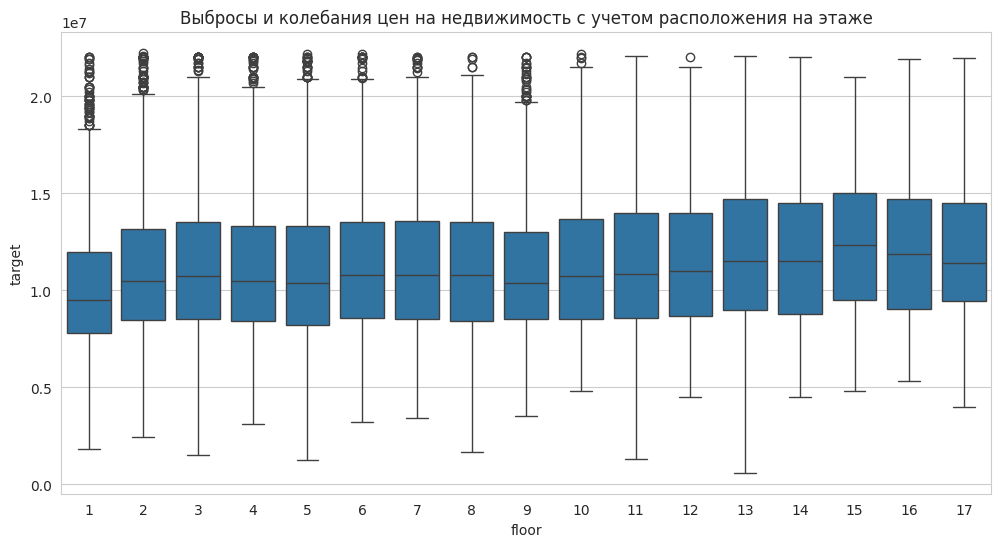

In [85]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x="floor", y="target", ax=ax)
plt.title('Выбросы и колебания цен на недвижимость с учетом расположения на этаже')
plt.show()

# Сохранение картинки в директорию
fig.savefig(os.path.join(ASSETS_DIR, 'floors_vs_target.png'))

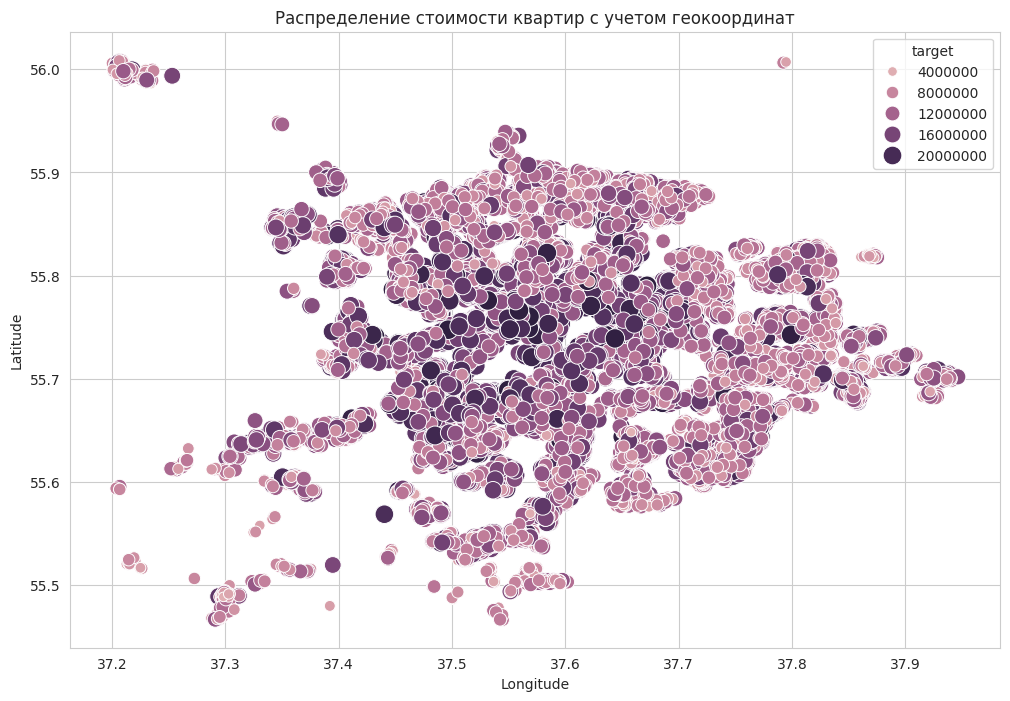

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(data=df, x='longitude', y='latitude', hue='target', size='target', sizes=(20, 200), ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Распределение стоимости квартир с учетом геокоординат')
plt.show()

# Сохранение картинки в директорию
fig.savefig(os.path.join(ASSETS_DIR, 'GEO_vs_target.png'))

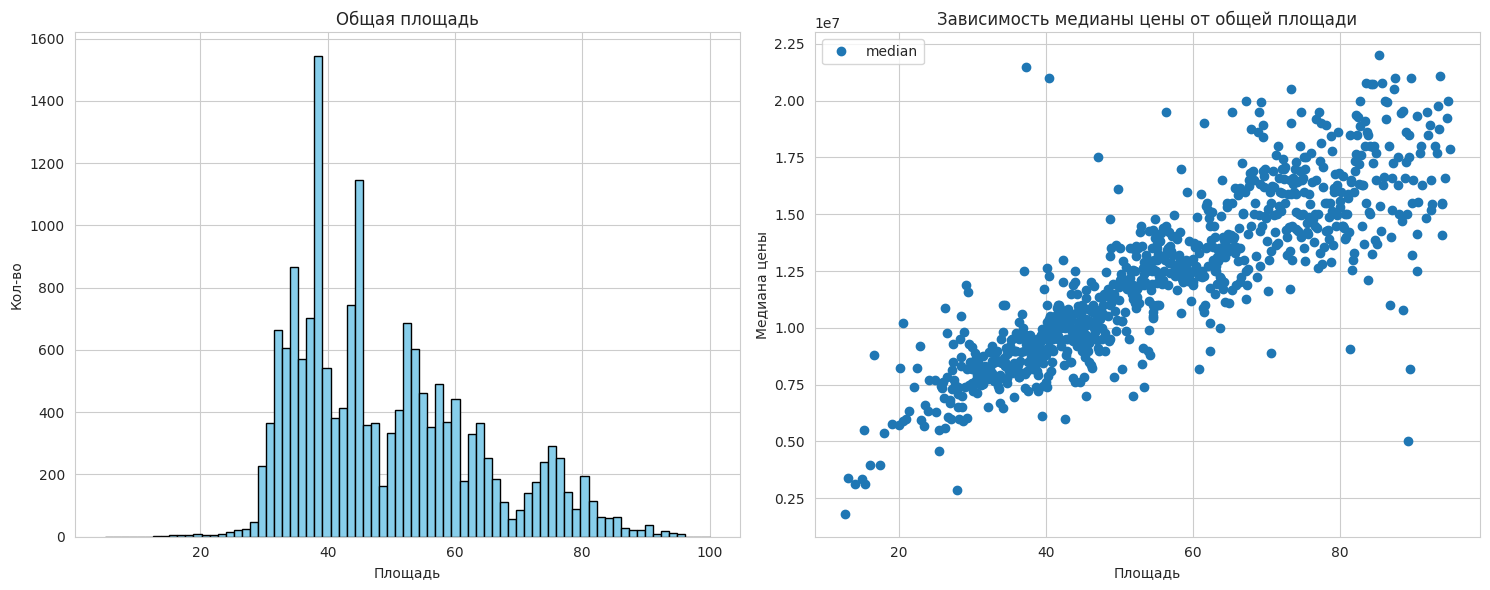

Коэффициент корреляции Пирсона: 0.6400728084749457


In [109]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# График распределения общей площади
axs[0].hist(df['total_area'], bins=75, range=(5, 100), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Площадь')
axs[0].set_ylabel('Кол-во')
axs[0].set_title('Общая площадь')
axs[0].grid(True)

# График зависимости медианы цены от общей площади
pivot_table_total_area = df.pivot_table(index='total_area', values='target', aggfunc=['median']).droplevel(level=1, axis=1)
pivot_table_total_area.sort_values('median', ascending=False).plot(y='median', style='o', ax=axs[1])
axs[1].set_xlabel('Площадь')
axs[1].set_ylabel('Медиана цены')
axs[1].set_title('Зависимость медианы цены от общей площади')

plt.tight_layout()
fig.savefig(os.path.join(ASSETS_DIR, 'total_area_vs_target'))

plt.show()
print('Коэффициент корреляции Пирсона:',df['total_area'].corr(df['target']))

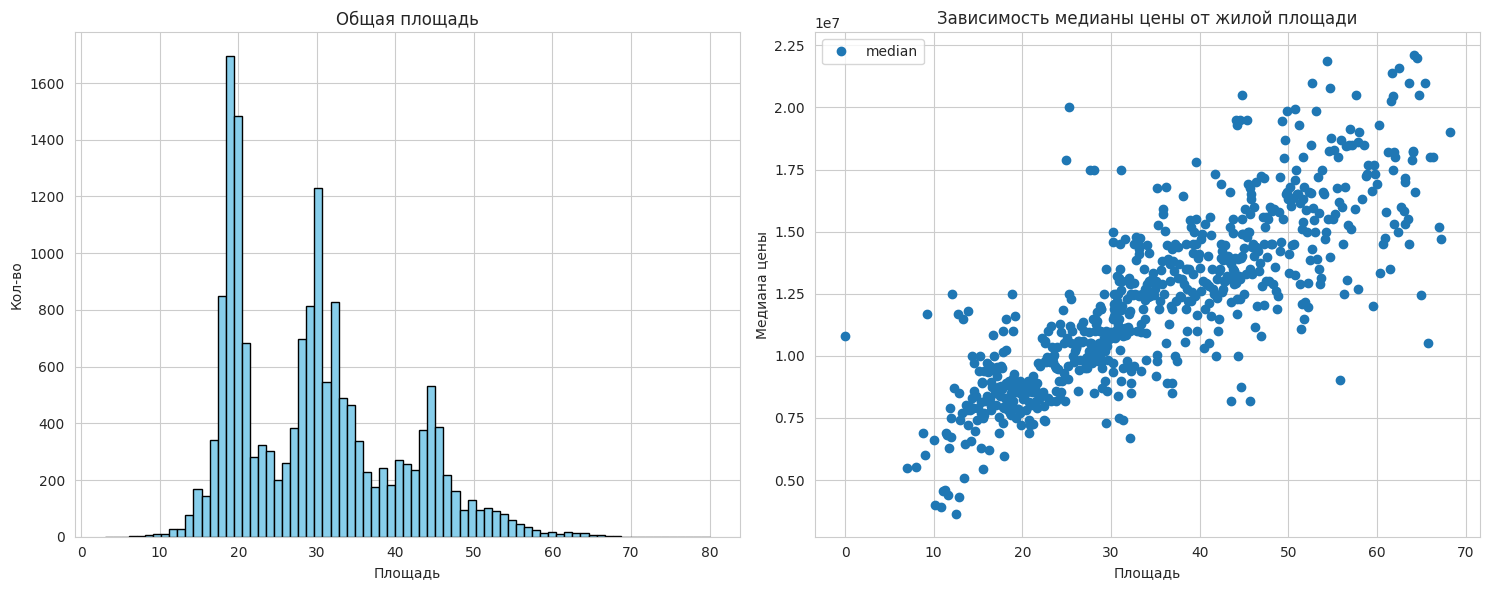

Коэффициент корреляции Пирсона: 0.49751645080256074


In [111]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# График распределения жилой площади
axs[0].hist(df['living_area'], bins=75, range=(3, 80), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Площадь')
axs[0].set_ylabel('Кол-во')
axs[0].set_title('Общая площадь')
axs[0].grid(True)

# График зависимости медианы цены от жилой площади
pivot_table_living_area = df.pivot_table(index='living_area', values='target', aggfunc=['median']).droplevel(level=1, axis=1)
pivot_table_living_area.sort_values('median', ascending=False).plot(y='median', style='o', ax=axs[1])
axs[1].set_xlabel('Площадь')
axs[1].set_ylabel('Медиана цены')
axs[1].set_title('Зависимость медианы цены от жилой площади')

plt.tight_layout()
fig.savefig(os.path.join(ASSETS_DIR, 'living_area_vs_target'))

plt.show()
print('Коэффициент корреляции Пирсона:',df['living_area'].corr(df['target']))

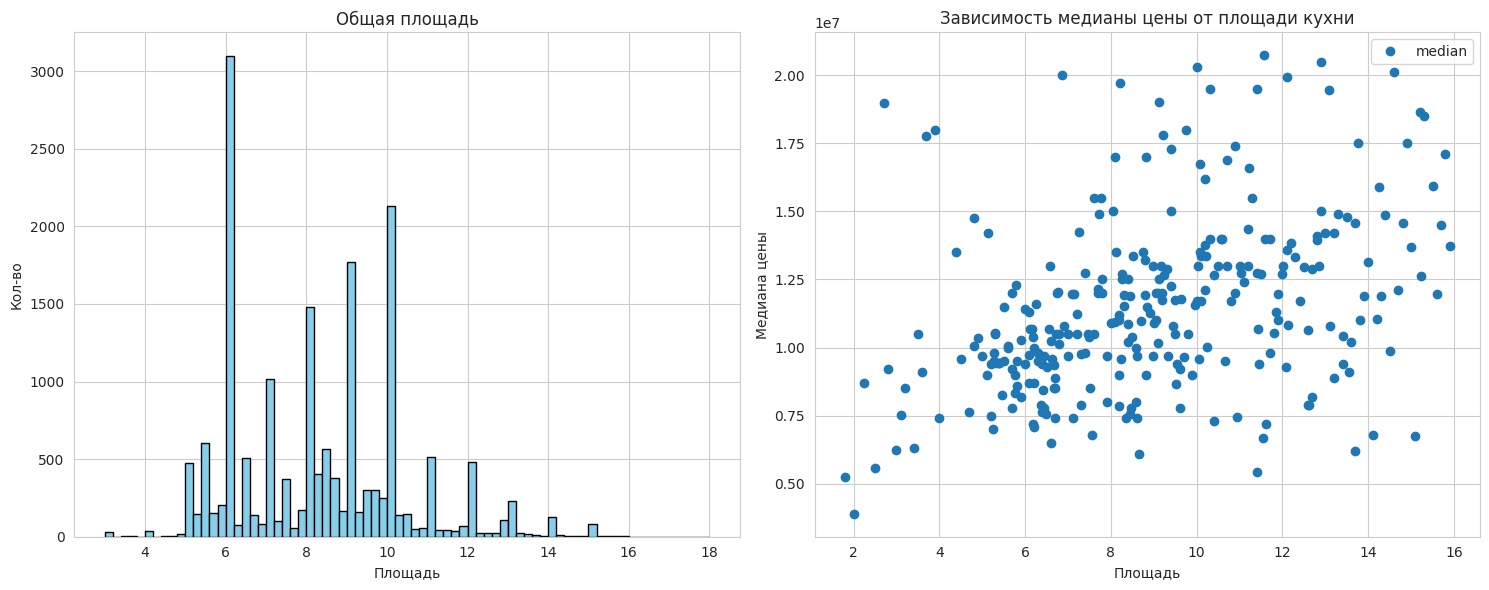

Коэффициент корреляции Пирсона: 0.2982826066599244


In [113]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# График распределения площади кухни
axs[0].hist(df['kitchen_area'], bins=75, range=(3, 18), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Площадь')
axs[0].set_ylabel('Кол-во')
axs[0].set_title('Общая площадь')
axs[0].grid(True)

# График зависимости медианы цены от площади кухни
pivot_table_kitchen_area = df.pivot_table(index='kitchen_area', values='target', aggfunc=['median']).droplevel(level=1, axis=1)
pivot_table_kitchen_area.sort_values('median', ascending=False).plot(y='median', style='o', ax=axs[1])
axs[1].set_xlabel('Площадь')
axs[1].set_ylabel('Медиана цены')
axs[1].set_title('Зависимость медианы цены от площади кухни')

plt.tight_layout()
fig.savefig(os.path.join(ASSETS_DIR, 'kitchen_area_vs_target'))

plt.show()
print('Коэффициент корреляции Пирсона:',df['kitchen_area'].corr(df['target']))

count    1.752100e+04
mean     1.122007e+07
std      3.724475e+06
min      6.000000e+05
25%      8.400000e+06
50%      1.050000e+07
75%      1.350000e+07
max      2.224400e+07
Name: target, dtype: float64


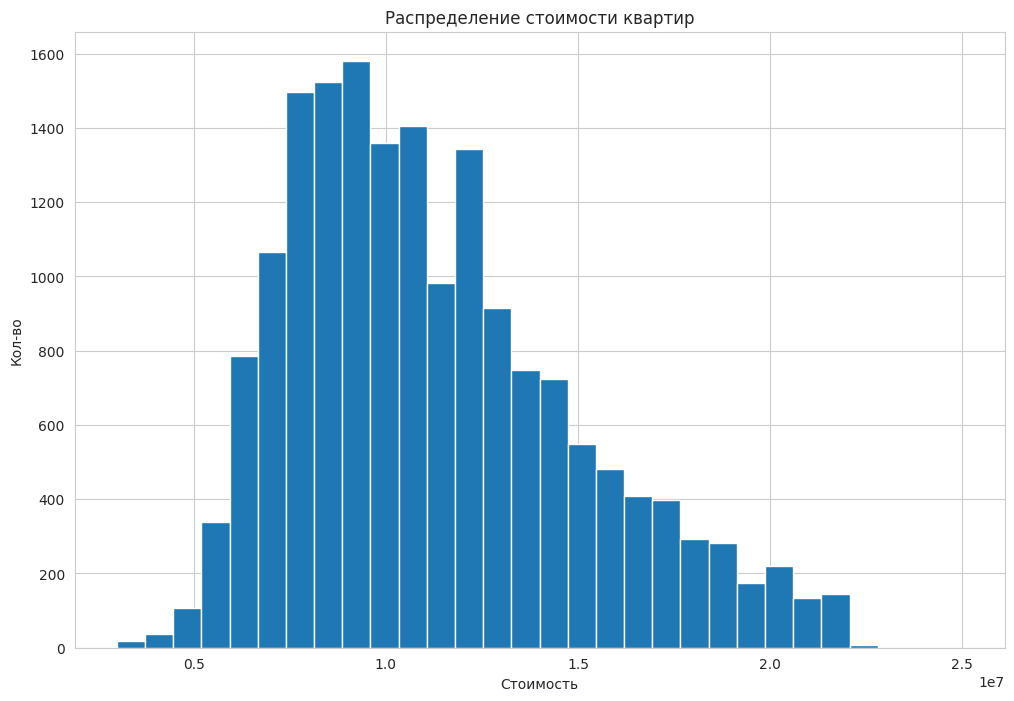

In [115]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df['target'].plot(kind='hist', bins=30, range=(3000000,25000000), title='Распределение стоимости квартир', grid=True)
ax.set_xlabel('Стоимость')
ax.set_ylabel('Кол-во')
print(df['target'].describe())
plt.savefig(os.path.join(ASSETS_DIR, 'target_scattering'))

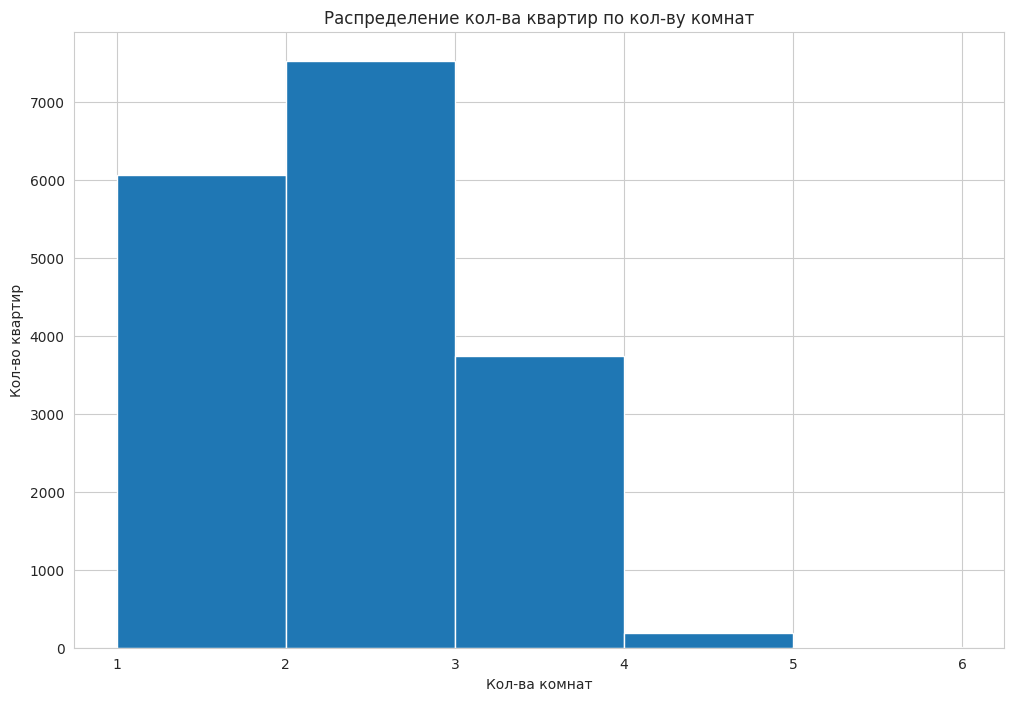

In [116]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df['rooms'].plot(kind='hist', bins=5, range=(1,6), title='Распределение кол-ва квартир по кол-ву комнат', grid=True)
ax.set_xlabel('Кол-ва комнат')
ax.set_ylabel('Кол-во квартир')
df['rooms'].describe()
plt.savefig(os.path.join(ASSETS_DIR, 'rooms_scattering'))

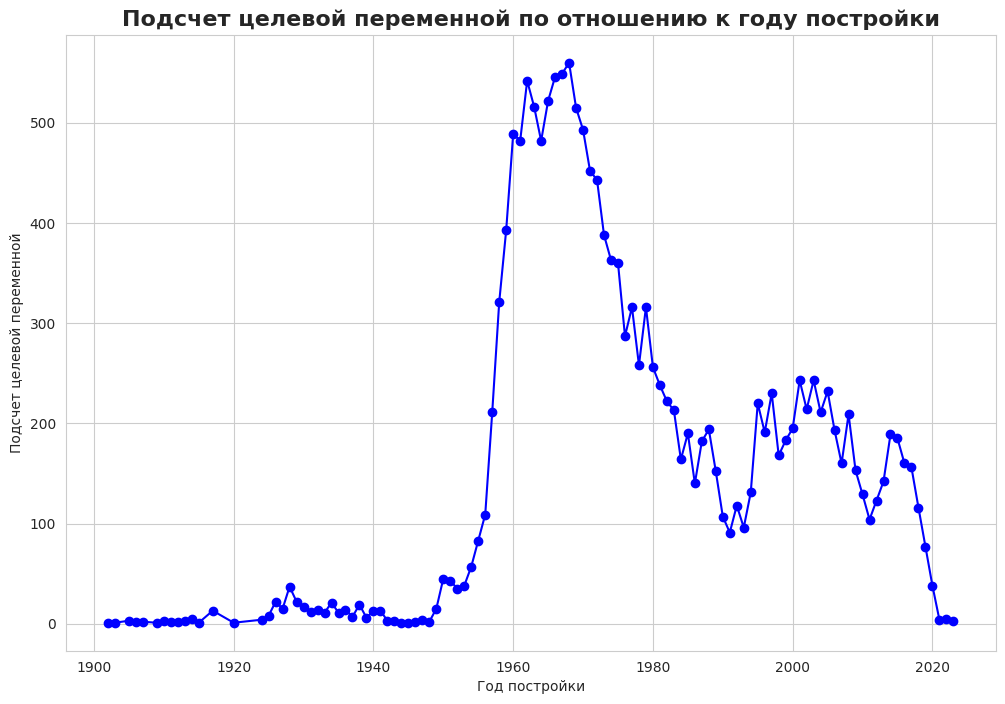

In [119]:
# Создание фигуры для графика
fig, ax = plt.subplots(figsize=(12, 8))

# Устанавливаем переменные
x = "build_year"
target = "target"
stat = ["count"]

# Агрегация количества целей по датам начала
target_agg_by_date = df.groupby([x]).agg({target: stat}).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# Построение графика
plt.plot(target_agg_by_date[x], target_agg_by_date["target_count"], marker='o', color='b')

# Настройка заголовка и меток оси
plt.xlabel('Год постройки')
plt.ylabel('Подсчет целевой переменной')
plt.title('Подсчет целевой переменной по отношению к году постройки', fontsize=16, fontweight='bold')

# Сохраняем график
plt.savefig(os.path.join(ASSETS_DIR, 'target_count_by_build_year'))

# Отображаем график
plt.show()

In [71]:
#display(df.describe())

In [72]:
#df.info()

**ВЫВОД** : 
Данные достаточно чистые, пропущенных значений и явных дубликатов нет. Неявные дубликаты искать думаю бесперспективно не располагая конкретными id квартир. Явных выбросов тоже нет, один из столбцов 'studio' содержал одно лишь значение False. Столбец удалил. Столбец living_area содержит не совсем 732 нулевых значения. Очевидно это ошибка в заполнении данных, была идея заполнить это наюлюдение разность между общей площадью и площадью кухни, но это не точное значение не учитывающее площадь санузлов и коридоров. Столбец 'build_year' привел к значению year, полагаю так проще будет в дальнейшем нормализовать.
Итого, в представленной выборке три очевидных категориальных признака: 'building_type_int', 'has_elevator', 'is_apartment', из них два бинарные, один признак с типом datetime и остальные выглядят как цисловые, хотя к-во комнат, этаж, могут вполне быть и категориальными.

Общая площадь в нашей выборке колеблется от 12.65 до 95, среднее значение 49.3,  а медиана 45. 
Цены на недвижимость имеют среднее значение в 11 220 070 млн руб., медиана 10 500 000 млн руб. Распределение данных Гаусса.
Количество комнат колеблется от 1 до 5. Больше всего двухкомнатных квартир.
Высота потолков в среднем составляет 2,7 м, медиана 2,6 м. 

Согласно статистических исследований, прослеживается определенная корреляция целевой переменной со общей площадью, но сильно высокой ее не назвать (коэффициент корреляции Пирсона в пределах 64%), ниже коэффициэнт корреляции с жилой площадью и что поразило, с площадью кухни. Самая распространенная площадь в районе 6 (полагаю м2). Удивлен но не заметил что этаж сильно влияет на целевую переменную. Больше всего предложений квартир построенных в 60-70.

Намеренно не оборачивал построение графиков в функции и не строил рядом, так проще было возвращаться и периодически корректировать данные.



In [120]:

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [26]:
EXPERIMENT_NAME = "Futures generation and model training"
RUN_NAME = "Nick_projecr _run_3"

In [10]:
#df.sample(5)

In [11]:
columns_list = df.columns.tolist()
columns_text = ",".join(columns_list) 
with open("columns.txt", "w", encoding="utf-8") as mns:
    mns.write(columns_text)
    
df.to_csv("flat_cleaned_churn", index=False)  

In [12]:
#фичей не так много, определяю их простым образом.
num_columns = ['ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area',
                    'living_area', 'rooms', 'total_area', 'latitude', 'longitude']
cat_columns = ['building_type_int', 'is_apartment', 'has_elevator']
data_columns = ['build_year']

In [13]:
#создаю словарь параметров.
params = {
    'categories': 'auto',
    'handle_unknown': 'ignore',
    'max_categories': 10,
    'sparse_output': False,
    'drop': 'first',
    'degree': 2,
    'n_bins': 5,
    'encode': 'ordinal',
    'strategy': 'uniform',
    'subsample': None,
}

In [15]:
encoder_sc =  StandardScaler()
encoder_oh = OneHotEncoder(categories = params['categories'], handle_unknown = params['handle_unknown'],
                           max_categories = params['max_categories'], sparse_output = params['sparse_output'], drop = params['drop'])

encoder_pol = PolynomialFeatures(degree = params['degree'])

encoder_kbd = KBinsDiscretizer(n_bins = params['n_bins'], encode = params['encode'], strategy = params['strategy'], subsample = params['subsample'])

encoder_mm = MinMaxScaler()

numeric_transformer = ColumnTransformer(transformers=[
                                                     ('sk', encoder_sc, num_columns),
                                                     ('pol', encoder_pol, num_columns), 
                                                     ('kbd', encoder_kbd, num_columns)
                                                     ])

data_transformer = ColumnTransformer(transformers=[('dt', encoder_mm, data_columns)])

categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

preprocessor =  ColumnTransformer(transformers=[('num', numeric_transformer, num_columns),
                                                ('dt', data_transformer, data_columns ),
                                                ('cat', categorical_transformer, cat_columns)], n_jobs=-1)

In [16]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  ColumnTransformer(transformers=[('sk',
                                                                                   StandardScaler(),
                                                                                   ['ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    'kitchen_area',
                                                                                    'living_area',
                                                                                    'rooms',
                                                                                    'total_area',
                                                                                    'latitude',
                                                                                    'longitude']),
                                                                                  ('pol',
                                                                                   PolynomialFeatures(),
                                                                                   ['ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    '...
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'total_area', 'latitude',
                                                   'longitude']),
                                                 ('dt',
                                                  ColumnTransformer(transformers=[('dt',
                                                                                   MinMaxScaler(),
                                                                                   ['build_year'])]),
                                                  ['build_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=10,
                                                                                 sparse_output=False))]),
                                                  ['building_type_int',
                                                   'is_apartment',
                                                   'has_elevator'])]))])

**Модель с автогенерацией параметров**

In [17]:
#Обновляю список признаков. В AutoFeatRegressor добавлю исключительно цифровые признаки
num_columns = ['ceiling_height', 'flats_count', 'floors_total', 'floor','rooms','latitude', 'longitude']
data_columns = ['build_year']
afr_columns = ['kitchen_area','living_area','total_area']
cat_columns = ['building_type_int', 'is_apartment','has_elevator']

In [18]:
# Обновлю список параметров
params['feateng_steps'] = 2 # применю умеренное количество шагов
params['featsel_runs'] = 3 # три подхода к выбору признаков
params['max_gb'] = None # предоставлю всю доступную память
params['n_jobs'] = -1 # количество параллельных задач
params['transformations'] = ('1/', 'log', 'abs', 'sqrt') 
params['units'] = None # не фиксирую единицу измерения
params['verbose'] = 0 # отключаю вывод информации

In [19]:
encoder_oh = OneHotEncoder(categories = params['categories'], handle_unknown = params['handle_unknown'],
                           max_categories = params['max_categories'], sparse_output = params['sparse_output'], drop = params['drop'])

encoder_pol = PolynomialFeatures(degree = params['degree'])

encoder_mm = MinMaxScaler()

encoder_kbd = KBinsDiscretizer(n_bins = params['n_bins'], encode = params['encode'], strategy = params['strategy'], subsample = params['subsample'])

encoder_afr = AutoFeatRegressor(feateng_steps = params['feateng_steps'], featsel_runs = params['featsel_runs'], 
                                max_gb = params['max_gb'], n_jobs = params['n_jobs'], transformations = params['transformations'],
                                units = params['units'], verbose = params['verbose'])
scaler = StandardScaler()

In [20]:
#Выборка не сказать что большая, применю простое разделение
X = df.drop('target', axis=1).copy()
y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = LinearRegression(fit_intercept=True)  
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('model', model)
    ]
    )

In [22]:
start_time = time.time() 
pipeline.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Время обучения:", training_time, "секунд")

Время обучения: 1.4691333770751953 секунд


In [23]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  ColumnTransformer(transformers=[('sk',
                                                                                   StandardScaler(),
                                                                                   ['ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    'kitchen_area',
                                                                                    'living_area',
                                                                                    'rooms',
                                                                                    'total_area',
                                                                                    'latitude',
                                                                                    'longitude']),
                                                                                  ('pol',
                                                                                   PolynomialFeatures(),
                                                                                   ['ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    '...
                                                   'total_area', 'latitude',
                                                   'longitude']),
                                                 ('dt',
                                                  ColumnTransformer(transformers=[('dt',
                                                                                   MinMaxScaler(),
                                                                                   ['build_year'])]),
                                                  ['build_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=10,
                                                                                 sparse_output=False))]),
                                                  ['building_type_int',
                                                   'is_apartment',
                                                   'has_elevator'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [24]:
start_time = time.time()
prediction = pipeline.predict(X_test)
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[10424185.83559753 10791673.83559753 12755300.07223027 ...
  9467325.58708919  9304873.83559753 14055933.58708918]
Время предсказания: 0.045517921447753906 секунд


In [25]:
metrics = {}
mean = y_test.mean() #среднее значение целевой переменной на тесте
MAE = mean_absolute_error(y_test, prediction)
MSE = mean_squared_error(y_test, prediction)
R2 = r2_score(y_test, prediction)
y_error = y_test - prediction
y_error = y_test - prediction  # рассчитаем вектор ошибок
y_error_abs = abs(y_error)  # рассчитаем вектор модуля ошибок
perc_error_abs = y_error_abs / y_test  # рассчитаем вектор относительных ошибок
mape = perc_error_abs.mean()  # рассчитаем MAPE
metrics['Среднее значение целевой переменной'] = mean.round(2)
metrics['Средний модуль ошибки '] = MAE.round(2)
metrics['Средняя квадратичная ошибка'] = MSE.round(2)
metrics['Коэффициент детерминации'] = R2.round(2) 
metrics['Средняя абсолютная ошибка в процентах '] = mape.round(2)

metrics

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки ': 1949631.58,
 'Средняя квадратичная ошибка': 5905251519023.58,
 'Коэффициент детерминации': 0.56,
 'Средняя абсолютная ошибка в процентах ': 0.19}

In [27]:
REGISTRY_MODEL_NAME = "auto_future_gen_model_nikolaimelnikov"

pip_requirements = '../requirements.txt' # ваш код здесь
signature = mlflow.models.infer_signature(X_test, prediction)# ваш код здесь
input_example = input_example = X_test[:10]# ваш код здесь
metadata = {'model_type': 'monthly'}# ваш код здесь

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

model_path = "mlflow_baseline_model"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(pipeline, model_path, pip_requirements=pip_requirements,
                             input_example=input_example, metadata=metadata, signature=signature,
                             registered_model_name=REGISTRY_MODEL_NAME, await_registration_for=6)

    # Дополнительные логгирования метрик и артефактов
    mlflow.log_metrics(metrics)
    mlflow.log_dict(params, "model_params.json") 
    mlflow.log_artifact("columns.txt", artifact_path="dataframe")
    mlflow.log_artifact("flat_cleaned_churn", artifact_path="dataframe")

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
2024-05-15 12:04:02,748 INFO: Found credentials in environment variables.
Successfully registered model 'auto_

# Обновляю сп

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 17521 non-null  int64  
 1   build_id           17521 non-null  int64  
 2   build_year         17521 non-null  int64  
 3   building_type_int  17521 non-null  object 
 4   latitude           17521 non-null  float64
 5   longitude          17521 non-null  float64
 6   ceiling_height     17521 non-null  float64
 7   flats_count        17521 non-null  int64  
 8   floors_total       17521 non-null  int64  
 9   has_elevator       17521 non-null  int64  
 10  floor              17521 non-null  int64  
 11  kitchen_area       17521 non-null  float64
 12  living_area        17521 non-null  float64
 13  rooms              17521 non-null  int64  
 14  is_apartment       17521 non-null  object 
 15  studio             17521 non-null  object 
 16  total_area         175

In [9]:
num_columns = ['build_year','ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area',
                    'living_area', 'rooms', 'total_area', 'latitude', 'longitude','has_elevator',]
cat_columns = ['building_type_int', 'is_apartment', 'studio']

Создаю список параметров

In [10]:
params = {
    'categories': 'auto',
    'handle_unknown': 'ignore',
    'max_categories': 10,
    'sparse_output': False,
    'drop': 'first',
    'degree': 2,
    'n_bins': 3,
    'encode': 'ordinal',
    'strategy': 'uniform',
    'subsample': None,
}

In [11]:
encoder_sc =  StandardScaler()
encoder_oh = OneHotEncoder(categories = params['categories'], handle_unknown = params['handle_unknown'],
                           max_categories = params['max_categories'], sparse_output = params['sparse_output'], drop = params['drop'])

encoder_pol = PolynomialFeatures(degree = params['degree'])

encoder_kbd = KBinsDiscretizer(n_bins = params['n_bins'], encode = params['encode'], strategy = params['strategy'], subsample = ['subsample'])

numeric_transformer = ColumnTransformer(transformers=[
                                                     ('sk', encoder_sc, num_columns),
                                                     ('pol', encoder_pol, num_columns), 
                                                     ('kbd', encoder_kbd, num_columns)
                                                     ])

categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

preprocessor =  ColumnTransformer(transformers=[('num', numeric_transformer, num_columns),
                                                ('cat', categorical_transformer, cat_columns)], n_jobs=-1)

In [12]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  ColumnTransformer(transformers=[('sk',
                                                                                   StandardScaler(),
                                                                                   ['build_year',
                                                                                    'ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    'kitchen_area',
                                                                                    'living_area',
                                                                                    'rooms',
                                                                                    'total_area',
                                                                                    'latitude',
                                                                                    'longitude',
                                                                                    'has_elevator']),
                                                                                  ('pol',
                                                                                   PolynomialFeatures(),
                                                                                   ['build_year',
                                                                                    'ceiling_heigh...
                                                                                    'has_elevator'])]),
                                                  ['build_year',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total', 'floor',
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'total_area', 'latitude',
                                                   'longitude',
                                                   'has_elevator']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=10,
                                                                                 sparse_output=False))]),
                                                  ['building_type_int',
                                                   'is_apartment',
                                                   'studio'])]))])

Обновляем список параметров

In [13]:
params['feateng_steps'] = 2 # применю умеренное количество шагов
params['featsel_runs'] = 2 # три подхода к выбору признаков
params['max_gb'] = None # предоставлю всю доступную память
params['n_jobs'] = -1 # количество параллельных задач
params['transformations'] = ('log', 'sqrt', '^2') 
params['units'] = None # не фиксирую единицу измерения
params['verbose'] = 0 # отключаю вывод информации

In [14]:
params

{'categories': 'auto',
 'handle_unknown': 'ignore',
 'max_categories': 10,
 'sparse_output': False,
 'drop': 'first',
 'degree': 2,
 'n_bins': 3,
 'encode': 'ordinal',
 'strategy': 'uniform',
 'subsample': None,
 'feateng_steps': 2,
 'featsel_runs': 2,
 'max_gb': None,
 'n_jobs': -1,
 'transformations': ('log', 'sqrt', '^2'),
 'units': None,
 'verbose': 0}

In [15]:
encoder_oh = OneHotEncoder(categories = params['categories'], handle_unknown = params['handle_unknown'],
                           max_categories = params['max_categories'], sparse_output = params['sparse_output'], drop = params['drop'])

encoder_pol = PolynomialFeatures(degree = params['degree'])

encoder_kbd = KBinsDiscretizer(n_bins = params['n_bins'], encode = params['encode'], strategy = params['strategy'], subsample = params['subsample'])

encoder_afr = AutoFeatRegressor(feateng_steps = params['feateng_steps'], featsel_runs = params['featsel_runs'], 
                                max_gb = params['max_gb'], n_jobs = params['n_jobs'], transformations = params['transformations'],
                                units = params['units'], verbose = params['verbose'])
scaler = StandardScaler()

In [16]:
numeric_transformer = ColumnTransformer(transformers=[

                                                     ('pol', encoder_pol, num_columns), 
                                                     ('kbd', encoder_kbd, num_columns),
                                                     ('afr', encoder_afr, num_columns)
                                                     ])

categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

preprocessor =  ColumnTransformer(transformers=[('num', numeric_transformer, num_columns),
                                                ('cat', categorical_transformer, cat_columns)], n_jobs=-1)

In [17]:
preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('num',
                                 ColumnTransformer(transformers=[('pol',
                                                                  PolynomialFeatures(),
                                                                  ['build_year',
                                                                   'ceiling_height',
                                                                   'flats_count',
                                                                   'floors_total',
                                                                   'floor',
                                                                   'kitchen_area',
                                                                   'living_area',
                                                                   'rooms',
                                                                   'total_area',
                                                                   'latitude',
                                                                   'longitude',
                                                                   'has_elevator']),
                                                                 ('kbd',
                                                                  KBinsDiscretizer(encode='ordinal',
                                                                                   n_bins=3,
                                                                                   strategy='uniform',
                                                                                   subsample=None...
                                                                   'has_elevator'])]),
                                 ['build_year', 'ceiling_height', 'flats_count',
                                  'floors_total', 'floor', 'kitchen_area',
                                  'living_area', 'rooms', 'total_area',
                                  'latitude', 'longitude', 'has_elevator']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                max_categories=10,
                                                                sparse_output=False))]),
                                 ['building_type_int', 'is_apartment',
                                  'studio'])])

In [18]:
X = df.drop('target', axis=1).copy()
y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
preprocessor.fit_transform(X_train, y_train)

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


array([[ 1.00000000e+00,  3.78691200e+17,  2.64000010e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.10453760e+18,  2.74000001e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  7.25846400e+17,  2.64000010e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.00000000e+00, -2.83996800e+17,  2.48000002e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.19914560e+18,  3.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.32537600e+18,  3.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [20]:
model = LinearRegression(fit_intercept=True)  
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('model', model)
    ]
    )

In [21]:
pipeline 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  ColumnTransformer(transformers=[('pol',
                                                                                   PolynomialFeatures(),
                                                                                   ['build_year',
                                                                                    'ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    'kitchen_area',
                                                                                    'living_area',
                                                                                    'rooms',
                                                                                    'total_area',
                                                                                    'latitude',
                                                                                    'longitude',
                                                                                    'has_elevator']),
                                                                                  ('kbd',
                                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                                    n_bins=3,
                                                                                                    s...
                                                   'flats_count',
                                                   'floors_total', 'floor',
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'total_area', 'latitude',
                                                   'longitude',
                                                   'has_elevator']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=10,
                                                                                 sparse_output=False))]),
                                                  ['building_type_int',
                                                   'is_apartment',
                                                   'studio'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [22]:
start_time = time.time() 
pipeline.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Время обучения:", training_time, "секунд")

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Время обучения: 19.48668122291565 секунд


In [23]:
start_time = time.time()
prediction = pipeline.predict(X_test)
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[ 9863572.82814424 10617364.82814424 13791092.82814424 ...
  9511700.82814424  8014484.82814424 13911572.82814424]
Время предсказания: 3.4120535850524902 секунд


In [24]:
metrics = {}
mean = y_test.mean() #среднее значение целевой переменной на тесте
MAE = mean_absolute_error(y_test, prediction)
MSE = mean_squared_error(y_test, prediction)
R2 = r2_score(y_test, prediction)
y_error = y_test - prediction
y_error = y_test - prediction  # рассчитаем вектор ошибок
y_error_abs = abs(y_error)  # рассчитаем вектор модуля ошибок
perc_error_abs = y_error_abs / y_test  # рассчитаем вектор относительных ошибок
mape = perc_error_abs.mean()  # рассчитаем MAPE
metrics['Среднее значение целевой переменной'] = mean.round(2)
metrics['Средний модуль ошибки '] = MAE.round(2)
metrics['Средняя квадратичная ошибка'] = MSE.round(2)
metrics['Коэффициент детерминации'] = R2.round(2) 
metrics['Средняя абсолютная ошибка в процентах '] = mape.round(2)

In [25]:
metrics

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки ': 1908144.46,
 'Средняя квадратичная ошибка': 5659546400226.17,
 'Коэффициент детерминации': 0.58,
 'Средняя абсолютная ошибка в процентах ': 0.19}

*ВЫБОР ПРИЗНАКОВ*

In [26]:
!pip install mlxtend

In [27]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [28]:
X_train_processed = preprocessor.transform(X_train)

In [29]:
X_train_processed.shape

(14016, 140)

In [30]:
scaler = StandardScaler()
model = LinearRegression(fit_intercept=True)  
pipe = Pipeline(
    [
        ('scaler', scaler),
        ('model', model)
    ]
    )

In [31]:
sfs =  SFS(estimator = pipe, k_features=12, forward=True, floating=False, scoring= 'neg_mean_squared_error', cv=5, n_jobs=-1)

In [32]:
sfs.fit(X_train_processed, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('model',
                                                     LinearRegression())]),
                          k_features=(12, 12), n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [33]:
top_sfs = sfs.k_feature_names_
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
-6282339998330.096


In [34]:
top_sfs

('10', '11', '13', '32', '85', '88', '100', '101', '116', '119', '121', '136')

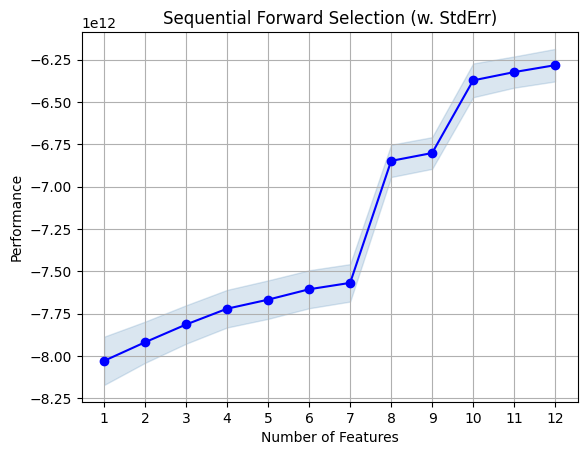

In [74]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

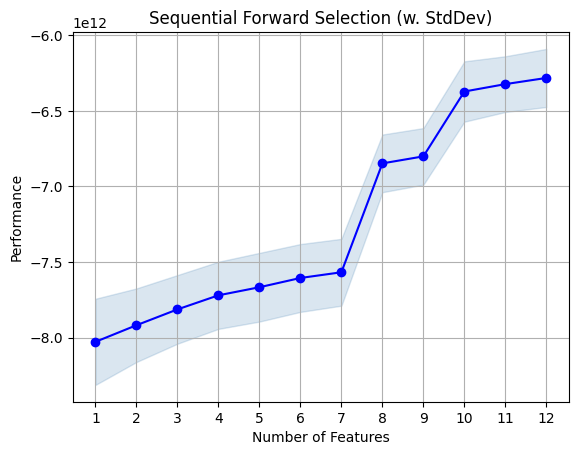

In [35]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [36]:
sbs =  SFS(estimator = pipe, k_features=12, forward=False, floating=False, scoring= 'neg_mean_squared_error', cv=5, n_jobs=-1)

In [37]:
sbs.fit(X_train_processed, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('model',
                                                     LinearRegression())]),
                          forward=False, k_features=(12, 12), n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [38]:
top_sbs = sbs.k_feature_names_
print('\nSequential Forward Selection (k=12)')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=12)
CV Score:
-6060504072672.602


In [39]:
top_sbs

('1', '13', '23', '85', '86', '88', '111', '112', '113', '119', '124', '127')

In [71]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [73]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(32,)","[-7939570039914.99, -8507055358096.033, -81760...",-8028097215847.729492,"(32,)",366340539965.594238,285025385885.42804,142512692942.71402
2,"(32, 136)","[-7868363048646.79, -8317303692234.605, -80503...",-7918252197530.123047,"(32, 136)",312664965008.83075,243263965033.369049,121631982516.684509
3,"(32, 101, 136)","[-7747943991681.121, -8190404843122.709, -7934...",-7813525291549.114258,"(32, 101, 136)",291628701662.296265,226897037478.759369,113448518739.379669
4,"(32, 101, 121, 136)","[-7671072213714.38, -8106734383826.577, -77974...",-7720330164596.59375,"(32, 101, 121, 136)",285387309008.547913,222041021953.521027,111020510976.760513
5,"(32, 101, 116, 121, 136)","[-7636271546697.745, -8065324647456.785, -7729...",-7666936061886.763672,"(32, 101, 116, 121, 136)",291931879876.250732,227132920429.176331,113566460214.58815
6,"(32, 101, 116, 119, 121, 136)","[-7519487694537.06, -7990993718064.034, -77155...",-7605642909964.203125,"(32, 101, 116, 119, 121, 136)",288383166617.906555,224371900952.731598,112185950476.365784
7,"(10, 32, 101, 116, 119, 121, 136)","[-7458678459173.149, -7960823043876.963, -7658...",-7567881558857.962891,"(10, 32, 101, 116, 119, 121, 136)",284169331481.13446,221093394058.493652,110546697029.246811
8,"(10, 32, 85, 101, 116, 119, 121, 136)","[-6726294950943.988, -7207568701631.62, -68541...",-6847538061159.837891,"(10, 32, 85, 101, 116, 119, 121, 136)",245130708990.042145,190720019490.109375,95360009745.054688
9,"(10, 32, 85, 88, 101, 116, 119, 121, 136)","[-6699411214999.923, -7134229549322.438, -6831...",-6801144347884.241211,"(10, 32, 85, 88, 101, 116, 119, 121, 136)",240674232778.778625,187252729596.602356,93626364798.301178
10,"(10, 11, 32, 85, 88, 101, 116, 119, 121, 136)","[-6258988049554.176, -6744949280696.383, -6394...",-6372126632850.78418,"(10, 11, 32, 85, 88, 101, 116, 119, 121, 136)",256492629846.284332,199559979918.060577,99779989959.030289


In [72]:
sbs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
140,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-5803314392412.368, -6157793405621.376, -5856...",-5896063130893.9375,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",172126533010.99292,133920290386.607925,66960145193.303963
139,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-5803123946513.356, -6149723002480.816, -5851...",-5892228854638.393555,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",169224001442.577423,131662022217.843536,65831011108.921768
138,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-5800734457145.943, -6148041109678.138, -5850...",-5888507908926.275391,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",170825114864.960022,132907742855.542542,66453871427.771263
137,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-5791897999410.424, -6148591263993.806, -5849...",-5885276608740.955078,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",173260133504.148773,134802270082.417755,67401135041.20887
136,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-5785602180602.9375, -6147631960413.323, -584...",-5882518532484.80957,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",174513388765.597229,135777345253.024963,67888672626.512474
...,...,...,...,...,...,...,...
16,"(1, 13, 23, 34, 35, 50, 85, 86, 88, 111, 112, ...","[-5865485983310.967, -6246167169896.103, -5969...",-5974523672524.397461,"(1, 13, 23, 34, 35, 50, 85, 86, 88, 111, 112, ...",180199750599.812164,140201527944.445068,70100763972.222534
15,"(1, 13, 23, 34, 35, 50, 85, 86, 88, 111, 112, ...","[-5892839859024.721, -6245723321135.795, -6009...",-5997216050981.951172,"(1, 13, 23, 34, 35, 50, 85, 86, 88, 111, 112, ...",167593674899.047852,130393572779.426453,65196786389.713219
14,"(1, 13, 23, 34, 50, 85, 86, 88, 111, 112, 113,...","[-5912344099605.534, -6249079945704.473, -6016...",-6007230049604.095703,"(1, 13, 23, 34, 50, 85, 86, 88, 111, 112, 113,...",162596222844.872498,126505385301.406586,63252692650.703293
13,"(1, 13, 23, 50, 85, 86, 88, 111, 112, 113, 119...","[-5916173870490.034, -6272766065400.417, -6023...",-6026254175456.831055,"(1, 13, 23, 50, 85, 86, 88, 111, 112, 113, 119...",164907805671.402588,128303875272.513092,64151937636.256546


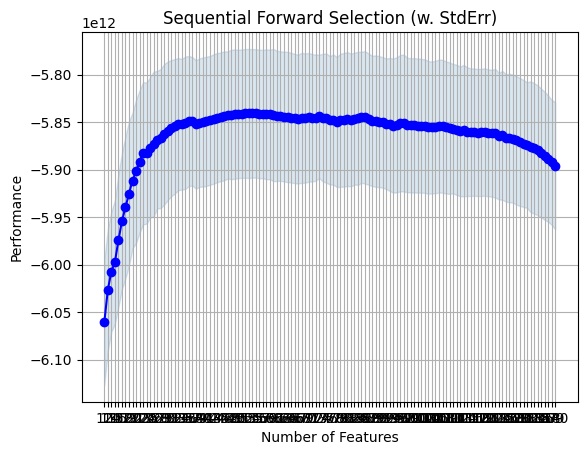

In [75]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

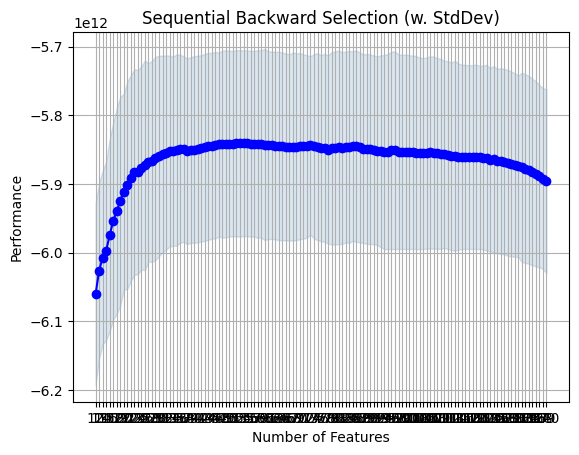

In [40]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

In [41]:
interc_features = list(set(top_sbs) & set(top_sfs)) # ваш код здесь #
union_features = list(set(top_sbs) | set(top_sfs)) # ваш код здесь #

In [44]:
interc_features

['13', '88', '85', '119']

In [45]:
union_features

['10',
 '111',
 '23',
 '86',
 '85',
 '32',
 '101',
 '13',
 '1',
 '127',
 '119',
 '124',
 '11',
 '121',
 '112',
 '88',
 '113',
 '116',
 '136',
 '100']

In [42]:
from sklearn.metrics import mean_squared_error

def train_and_evaluate_model(features, target):
    scaler = StandardScaler()
    model = LinearRegression(fit_intercept=True)  
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    
    # Обучение модели
    pipe.fit(features, target)
    
    # Предсказание на обучающих данных
    predictions = pipe.predict(features)
    
    # Оценка качества модели с помощью MSE
    mse = mean_squared_error(target, predictions)
    
    return pipe, predictions, mse

In [70]:
# Обучение модели на пересекающихся признаках
start_time = time.time() 
model_interc, predictions_interc, mse_interc = train_and_evaluate_model(X_train_processed[:, np.array(interc_features, dtype=int)], y_train)

# Обучение модели на объединяющихся признаках
model_union, predictions_union, mse_union = train_and_evaluate_model(X_train_processed[:, np.array(union_features, dtype=int)], y_train)
end_time = time.time()
training_time = end_time - start_time
# Вывод метрик для сравнения
print("MSE for Intersection Features:", mse_interc)
print("MSE for Union Features:", mse_union)
print("Время обучения:", training_time, "секунд")

MSE for Intersection Features: 12985897659933.014
MSE for Union Features: 5961688887656.746
Время обучения: 0.03067779541015625 секунд


In [56]:
model_interc

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [58]:
X_test_processed = preprocessor.transform(X_test)

In [59]:
X_test_processed_selected_int = X_test_processed[:, np.array(interc_features, dtype=int)]

In [60]:
start_time = time.time()
prediction = model_interc.predict(X_test_processed_selected_int)
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[11644179.13561395 12665027.29741357 12041561.78992574 ...
  9643906.95196229 10332829.58214021 10797532.74848904]
Время предсказания: 0.005254507064819336 секунд


In [61]:
metrics = {}
mean = y_test.mean() #среднее значение целевой переменной на тесте
MAE = mean_absolute_error(y_test, prediction)
MSE = mean_squared_error(y_test, prediction)
R2 = r2_score(y_test, prediction)
y_error = y_test - prediction
y_error = y_test - prediction  # рассчитаем вектор ошибок
y_error_abs = abs(y_error)  # рассчитаем вектор модуля ошибок
perc_error_abs = y_error_abs / y_test  # рассчитаем вектор относительных ошибок
mape = perc_error_abs.mean()  # рассчитаем MAPE
metrics['Среднее значение целевой переменной'] = mean.round(2)
metrics['Средний модуль ошибки '] = MAE.round(2)
metrics['Средняя квадратичная ошибка'] = MSE.round(2)
metrics['Коэффициент детерминации'] = R2.round(2) 
metrics['Средняя абсолютная ошибка в процентах '] = mape.round(2)

In [62]:
metrics

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки ': 2892223.05,
 'Средняя квадратичная ошибка': 12857676075997.24,
 'Коэффициент детерминации': 0.05,
 'Средняя абсолютная ошибка в процентах ': 0.29}

In [63]:
X_test_processed_selected_un = X_test_processed[:, np.array(union_features, dtype=int)]

In [65]:
start_time = time.time()
prediction = model_union.predict(X_test_processed_selected_un)
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[ 9943058.62101052 10810713.27644608 13508127.16614125 ...
  9514291.85515854  8090567.9598758  14285490.02838108]
Время предсказания: 0.003820180892944336 секунд


In [66]:
metrics = {}
mean = y_test.mean() #среднее значение целевой переменной на тесте
MAE = mean_absolute_error(y_test, prediction)
MSE = mean_squared_error(y_test, prediction)
R2 = r2_score(y_test, prediction)
y_error = y_test - prediction
y_error = y_test - prediction  # рассчитаем вектор ошибок
y_error_abs = abs(y_error)  # рассчитаем вектор модуля ошибок
perc_error_abs = y_error_abs / y_test  # рассчитаем вектор относительных ошибок
mape = perc_error_abs.mean()  # рассчитаем MAPE
metrics['Среднее значение целевой переменной'] = mean.round(2)
metrics['Средний модуль ошибки '] = MAE.round(2)
metrics['Средняя квадратичная ошибка'] = MSE.round(2)
metrics['Коэффициент детерминации'] = R2.round(2) 
metrics['Средняя абсолютная ошибка в процентах '] = mape.round(2)

In [67]:
metrics

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки ': 1917540.34,
 'Средняя квадратичная ошибка': 5678520561681.66,
 'Коэффициент детерминации': 0.58,
 'Средняя абсолютная ошибка в процентах ': 0.19}

In [80]:
from sklearn.model_selection import GridSearchCV

# Определение параметров для GridSearchCV
parameters = {
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__n_jobs': [-1, 1, 2, 4],
    'model__positive': [True, False]
}

def train_and_evaluate_model(features, target):
    scaler = StandardScaler()
    model = LinearRegression()  
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    
    # Определение GridSearchCV
    grid_search = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Обучение модели с поиском по сетке
    grid_search.fit(features, target)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    
    # Получение предсказаний на обучающих данных с лучшей моделью
    predictions = grid_search.predict(features)
    
    # Оценка качества модели с помощью MSE
    mse = mean_squared_error(target, predictions)
    
    return grid_search, predictions, mse, best_params

In [81]:
# Обучение модели на интерцептирующихся признаках с поиском по сетке
start_time = time.time() 
model_interc, predictions_interc, mse_interc, best_params_interc = train_and_evaluate_model(X_train_processed[:, np.array(interc_features, dtype=int)], y_train)

# Обучение модели на объединяющихся признаках с поиском по сетке
model_union, predictions_union, mse_union, best_params_union = train_and_evaluate_model(X_train_processed[:, np.array(union_features, dtype=int)], y_train)
end_time = time.time()
training_time = end_time - start_time

In [82]:
# Вывод метрик для сравнения
print("MSE for Intersection Features:", mse_interc)
print("MSE for Union Features:", mse_union)
print("Время обучения:", training_time, "секунд")
print("Лучшие параметры для Intersection Features:", best_params_interc)
print("Лучшие параметры для Union Features:", best_params_union)

MSE for Intersection Features: 12985897659933.014
MSE for Union Features: 5961688887656.746
Время обучения: 3.835792303085327 секунд
Лучшие параметры для Intersection Features: {'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': -1, 'model__positive': False}
Лучшие параметры для Union Features: {'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': -1, 'model__positive': False}
